# Install Requirements

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load Language Model

In [3]:
MODEL_NAME = "roberta-base"

# MODEL_NAME = "xlm-roberta-base" # cross-lingual mode (https://huggingface.co/xlm-roberta-base)


In [4]:
from transformers import RobertaModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
# model: FeatureExtractionPipeline = pipeline(
#    "feature-extraction", model=MODEL_NAME, tokenizer=tokenizer
# )


/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load Data

In [5]:
from pathlib import Path

DATA_DIR = Path.cwd() / "data"


## SemEval 2020 (C)COHA corpus

### Download

In [6]:
from io import BytesIO
from zipfile import ZipFile
import urllib

SEMEVAL_DATA_URL = (
    "https://www2.ims.uni-stuttgart.de/data/sem-eval-ulscd/semeval2020_ulscd_eng.zip"
)

SEMEVAL2020_DIR = DATA_DIR / "semeval2020_ulscd_eng"

if SEMEVAL2020_DIR.is_dir():
    print(f"Directory '{SEMEVAL2020_DIR}' already exists, skipping corpus download.")
else:
    with urllib.request.urlopen(SEMEVAL_DATA_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(DATA_DIR)

assert SEMEVAL2020_DIR.is_dir(), f"Directory does not exist: '{SEMEVAL2020_DIR}'"


Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/semeval2020_ulscd_eng' already exists, skipping corpus download.


In [7]:
CORPUS1_DIR = SEMEVAL2020_DIR / "corpus1"
CORPUS2_DIR = SEMEVAL2020_DIR / "corpus2"
TRUTH_DIR = SEMEVAL2020_DIR / "truth"

assert CORPUS1_DIR.is_dir(), f"Directory does not exist: '{CORPUS1_DIR}'"
assert CORPUS2_DIR.is_dir(), f"Directory does not exist: '{CORPUS2_DIR}'"
assert TRUTH_DIR.is_dir(), f"Directory does not exist: '{TRUTH_DIR}'"


### Read

In [8]:
TOKENS_FILE1 = CORPUS1_DIR / "token" / "ccoha1.txt.gz"
TOKENS_FILE2 = CORPUS2_DIR / "token" / "ccoha2.txt.gz"

assert TOKENS_FILE1.is_file()
assert TOKENS_FILE2.is_file()


In [9]:
import gzip

with gzip.open(TOKENS_FILE1, "rt") as f:
    sentences_1810 = f.readlines()

assert len(sentences_1810) == 253644

with gzip.open(TOKENS_FILE2, "rt") as f:
    sentences_1960 = f.readlines()

assert len(sentences_1960) == 353692


## COHA Corpus (Sample)

### Download

In [10]:
# COHA_DATABASE_URL = 'https://www.corpusdata.org/coha/samples/database.zip'
COHA_TEXT_URL = "https://www.corpusdata.org/coha/samples/text.zip"

COHA_DIR = DATA_DIR / "COHA"

try:
    COHA_DIR.mkdir(parents=True, exist_ok=False)
except OSError as e:
    print(f"Directory '{COHA_DIR}' already exists: {str(e)}. Skipping corpus download.")
else:
    with urllib.request.urlopen(COHA_TEXT_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(COHA_DIR)

assert COHA_DIR.is_dir()


Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA' already exists: [Errno 17] File exists: '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA'. Skipping corpus download.


### Read CohaDocs

In [11]:
from src import CohaDoc

coha_docs = [CohaDoc(file) for file in COHA_DIR.glob("*.txt")]

assert len(coha_docs) == 1144


(array([ 12.,  13.,  24.,  50.,  60., 156., 206., 188., 247., 188.]),
 array([1817. , 1836.2, 1855.4, 1874.6, 1893.8, 1913. , 1932.2, 1951.4,
        1970.6, 1989.8, 2009. ]),
 <BarContainer object of 10 artists>)

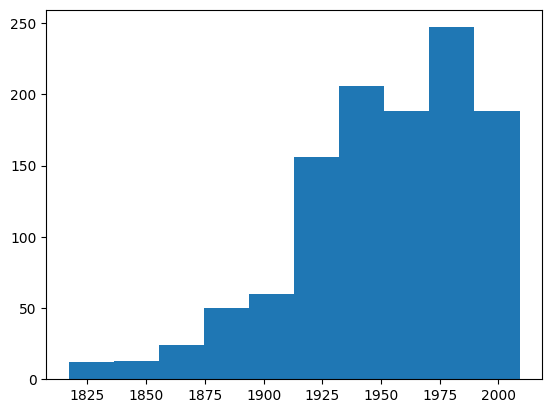

In [12]:
plt.hist([c.year for c in coha_docs])


(array([586.,   0.,   0., 424.,   0.,   0., 108.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

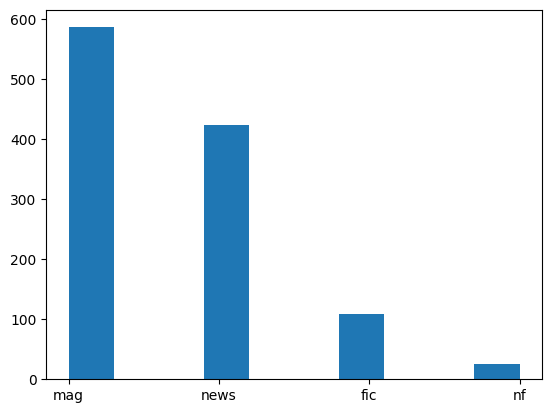

In [13]:
plt.hist([c.genre for c in coha_docs])


# Embeddings

In [17]:
TERM = "cell"



## Find Relevant Sentences

In [18]:
from typing import List

from tqdm import tqdm

from src import Text

sentence_candidates: List[Text] = [
    Text(
        text=s,
        metadata={"year": doc.year, "filename": doc._path.name},
        model=model,
        tokenizer=tokenizer,
    )
    for doc in tqdm(coha_docs, unit="doc")
    for s in doc.find_sentences(TERM)
]

print(len(sentence_candidates))


100%|██████████| 1144/1144 [00:00<00:00, 1616.90doc/s]

622


## Compute Embeddings

In [19]:
embeddings = []  # Changed into array below for efficiency
sentences = []

MAX_SENTENCES = None

for sentence in tqdm(
    sentence_candidates[:MAX_SENTENCES], unit="text", desc=f"Embeddings for '{TERM}'"
):
    for embedding in sentence.embeddings_matrix(TERM):
        embeddings.append(embedding)
        sentences.append(sentence)

assert len(embeddings) == len(sentences)
len(embeddings)


Embeddings for 'cell': 100%|██████████| 622/622 [00:34<00:00, 18.02text/s]


59

In [20]:
embeddings = np.array([e.detach().numpy() for e in embeddings])

assert embeddings.shape == (
    len(sentences),
    model.config.hidden_size,
), f"Shape {embeddings.shape} does not match expected shape {(len(sentences), model.config.hidden_size)}"
embeddings.shape


(59, 768)

# Plot

## PCA

In [21]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(embeddings)


Text(0.5, 1.0, "PCA Embeddings projections for 'cell'")

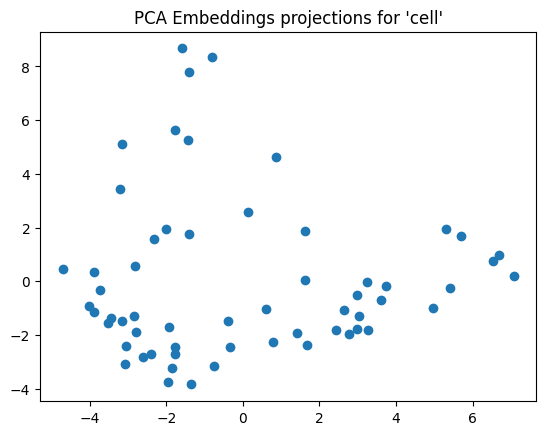

In [22]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], label=TERM)
plt.title(f"PCA Embeddings projections for '{TERM}'")


## UMAP

In [23]:
def get_decade(sentence: Text) -> str:
    start = int(sentence.metadata["year"] / 10) * 10
    end = start + 10
    return f"{start} - {end}"


hover_data = pd.DataFrame(
    data={
        "doc": [sentence.metadata["filename"] for sentence in sentences],
        "text": [sentence.text for sentence in sentences],
        "year": [sentence.metadata["year"] for sentence in sentences],
        "decade": [get_decade(sentence) for sentence in sentences],
    }
)

assert len(hover_data) == len(
    embeddings
), f"Number of embeddings ({len(embeddings)}) must equal number of sentence data points ({len(hover_data)})."
hover_data


,doc,text,year,decade
0,fic_1979_10650.txt,"A bulky television set , incongruous in the ce...",1979,1970 - 1980
1,fic_1979_10650.txt,"Some relevant information , however incomplete...",1979,1970 - 1980
2,fic_1979_10650.txt,Yet to break off contact while New York was st...,1979,1970 - 1980
3,nf_1994_746850.txt,Alternative systems include projection from be...,1994,1990 - 2000
4,mag_1981_494150.txt,Before Joanne Chesimard escaped she had amasse...,1981,1980 - 1990
5,mag_1995_426450.txt,<p> Mitochondrial DNA is located outside a cel...,1995,1990 - 2000
6,mag_1995_426450.txt,There were also passing references to the prac...,1995,1990 - 2000
7,nf_1884_748750.txt,The whole scene was almost as uncanny as the w...,1884,1880 - 1890
8,nf_1884_748750.txt,"This was the Heart of Midlothian , the condemn...",1884,1880 - 1890
9,nf_1884_748750.txt,.. Long after the condemned cell had been pull...,1884,1880 - 1890


In [24]:
import umap

mapper = umap.UMAP().fit(embeddings)


In [25]:
import umap.plot

umap.plot.output_notebook()

title = f"UMAP Embeddings Projections for '{TERM}'"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loading BokehJS ...

### Points (static)

Text(0.5, 1.0, "UMAP Embeddings Projections for 'cell'")

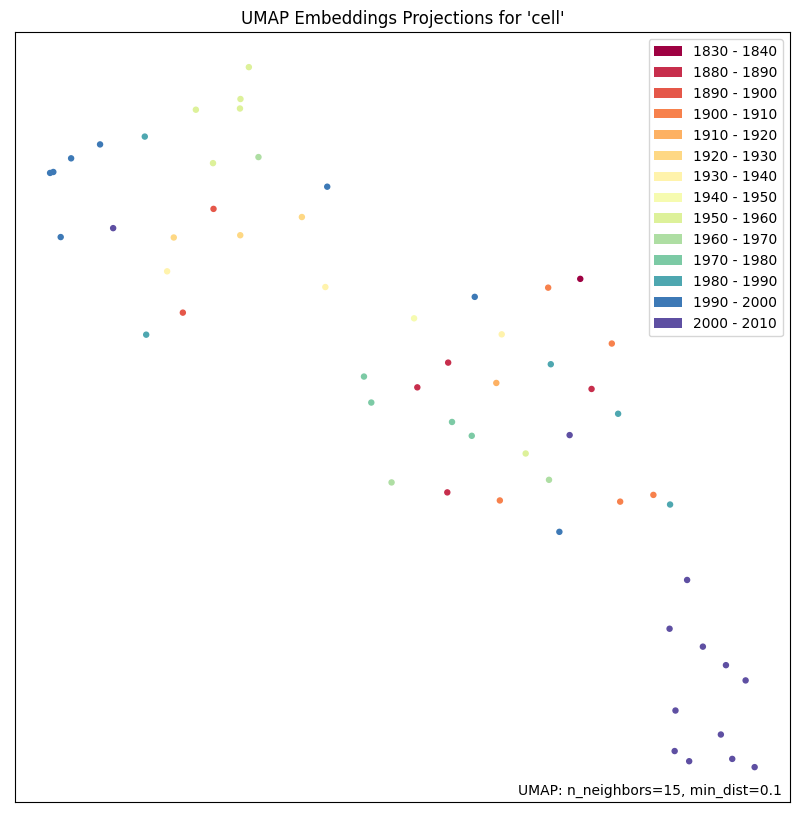

In [26]:
subplot = umap.plot.points(mapper, height=1000, width=1000, labels=hover_data["decade"])
subplot.set_title(title)


### Interactive Plot (using Bokeh)

In [27]:
from bokeh.models import ColumnDataSource

cds = ColumnDataSource(
    data={"x": mapper.embedding_[:, 0], "y": mapper.embedding_[:, 1],}
    | hover_data.to_dict("list")
)

cds


ColumnDataSource(id='1003', ...)

In [28]:
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
import bokeh.palettes

categories = hover_data.decade.unique()
palette = bokeh.palettes.Category20[len(categories)]

assert len(palette) >= len(
    categories
), f"Palette has only {len(palette)} categories, but {len(categories)} needed."

color_mapper = CategoricalColorMapper(factors=categories, palette=palette)
color_mapper


CategoricalColorMapper(id='1008', ...)

In [30]:
from bokeh.models.tickers import SingleIntervalTicker
from bokeh.plotting import figure, output_file, show


output_filename = f"{TERM}.html"
output_file(output_filename, title=title)

p = figure(
    height=1000,
    width=1000,
    tooltips=[("doc", "@doc"), ("text", "@text"), ("year", "@year")],
)
p.title = title

# TODO: group by decade to enable muting decades individually via legend
p.dot(
    x="x",
    y="y",
    legend_field="decade",
    source=cds,
    size=20,
    color={"field": "decade", "transform": color_mapper},
)

p.legend.click_policy = "mute"

p.xaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)
p.yaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)

show(p)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
